In [2]:
import pickle
import psutil
import sys
from pathlib import Path
from typing import Dict, List, Union

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, TargetEncoder
from xgboost import XGBClassifier

from fwi_predict.constants import TIMEZONE, WQ_RANGES
from fwi_predict.wq import get_in_required_range

sys.path.append("..")
from scripts.clean_ara_measurements import column_map

In [3]:
# Dictionary mapping model names to their configurations for RandomizedSearchCV
models = {
    # 'Random Forest': {
    #     'model': RandomForestClassifier(random_state=42),
    #     'n_iter': 20, # Number of parameter settings sampled
    #     'params': {
    #         'classifier__n_estimators': np.arange(100, 500, 100),
    #         'classifier__max_depth': [10, 20, 30, None],
    #         'classifier__min_samples_split': np.arange(2, 21, 3),
    #         'classifier__min_samples_leaf': np.arange(1, 11, 2),
    #         'classifier__max_features': ['sqrt', 'log2', None]
    #     }
    # },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'n_iter': 25,
        'params': {
            'classifier__n_estimators': np.arange(100, 500, 100),
            'classifier__max_depth': np.arange(3, 11, 2),
            'classifier__learning_rate': np.logspace(-3, -1, 10),
            'classifier__subsample': np.linspace(0.6, 1.0, 5),
            'classifier__colsample_bytree': np.linspace(0.6, 1.0, 5),
            'classifier__min_child_weight': np.arange(1, 7, 1),
            'classifier__gamma': np.linspace(0, 0.5, 6),
            'classifier__reg_alpha': np.logspace(-3, 1, 10),
            'classifier__reg_lambda': np.logspace(-3, 1, 10),
            'classifier__scale_pos_weight': [1]
        }
    },
    'Hist Gradient Boosting': {
        'model': HistGradientBoostingClassifier(random_state=42),
        'n_iter': 25,
        'params': {
            'classifier__max_iter': np.arange(100, 500, 100),
            'classifier__max_depth': np.arange(3, 11, 2),
            'classifier__learning_rate': np.logspace(-3, -1, 10),
            'classifier__min_samples_leaf': np.arange(10, 51, 10),
            'classifier__l2_regularization': np.logspace(-3, 1, 10),
            'classifier__max_bins': [128, 255],
            'classifier__early_stopping': [True],
            'classifier__validation_fraction': [0.1]
        }
    }
}

In [4]:
def create_pipeline(model_info, random_state: int = 42) -> Pipeline:
  """Create a scikit-learn pipeline for preprocessing and model training.
  
  Args:
    model_info: Dictionary containing model configuration
    cat_vars: Column names of categorical features.
    random_state: Random seed for reproducibility
      
  Returns:
    sklearn.pipeline.Pipeline: Configured pipeline
  """
  # Store pipeline steps
  steps = []

  steps.extend([
    ('scaler', StandardScaler()),
    ('classifier', model_info['model'])
  ])

  return Pipeline(steps)


def train_models(X_train: Union[pd.DataFrame, np.ndarray],
                 y_train: Union[pd.DataFrame, np.ndarray],
                 folds: int = 5,
                 workers = psutil.cpu_count(logical = False) - 1) -> Dict[str, BaseEstimator]:
    results = {}
    
    for name, model_info in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline
        param_grid = model_info['params'].copy()
        pipeline = create_pipeline(model_info)
        
        # Create CV object
        cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
        
        # Define scoring metrics for each class
        scoring = {
            'accuracy': 'accuracy',
            'precision_macro': 'precision_macro',
            'recall_macro': 'recall_macro',
            'f1_macro': 'f1_macro'
        }
        
        # Perform grid search with multiple scoring metrics
        grid_search = RandomizedSearchCV(
          pipeline, param_grid,
          cv=cv, scoring=scoring, 
          refit='accuracy', n_jobs=workers,
          n_iter=50,
          return_train_score=True
        )
        
        # Fit model
        grid_search.fit(X_train, y_train)
        
        # Get best model and score
        best_score = grid_search.best_score_
        best_pipeline = grid_search.best_estimator_
        
        print(f"Best CV accuracy score: {best_score:.3f}")
        
        # Store best model
        results[name] = best_pipeline
        
    return results

In [5]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/measurements_with_metadata_predict_df.csv", parse_dates=['sample_dt'])

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'pond_id', 'region', 'farm_id',
             'geometry', 'pond_area_acres', 'property_area_acres'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
predict_df['morning'] = predict_df['hour'] < 12
predict_df['time_of_day'] = predict_df['morning'].apply(lambda x: 'morning' if x else 'evening')
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  predict_df[range_name] = get_in_required_range(param, predict_df[param], predict_df['time_of_day'])

predict_df = predict_df.drop(columns=['morning', 'time_of_day', 'sample_dt'])
classify_df = predict_df.loc[:, ~predict_df.columns.isin(WQ_RANGES.keys())]
regress_df = predict_df[predict_df.columns[~predict_df.columns.str.endswith('_in_range')].tolist()]

In [6]:
target_columns = ['do_in_range', 'ph_in_range', 'ammonia_in_range', 'turbidity_in_range']  # Replace with actual target column names

In [7]:
final_models = {}
for target in target_columns:
		print(f"\nProcessing target: {target}")
		print("=" * 50)
		
		X_train = classify_df.drop(columns=target_columns)
		y_train = classify_df[target]
		
		valid_idx = y_train.astype(bool)
		X_train = X_train[valid_idx]
		y_train = y_train[valid_idx]
		
		le = LabelEncoder()
		ye = le.fit_transform(y_train)
		
		trained_models = train_models(X_train, ye) 	# Train and evaluate models
		final_models[target] = { 	# Store final models
				'models': trained_models,
				'encoder': le
		}


Processing target: do_in_range

Training XGBoost...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Best CV accuracy score: 0.858

Training Hist Gradient Boosting...
Best CV accuracy score: 0.853

Processing target: ph_in_range

Training XGBoost...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Best CV accuracy score: 0.925

Training Hist Gradient Boosting...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
100 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\squaade\Documen

Best CV accuracy score: nan

Processing target: ammonia_in_range

Training XGBoost...
Best CV accuracy score: 0.974

Training Hist Gradient Boosting...
Best CV accuracy score: 0.974

Processing target: turbidity_in_range

Training XGBoost...


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Best CV accuracy score: 0.916

Training Hist Gradient Boosting...
Best CV accuracy score: 0.917


In [9]:
model_dir = Path("..") / "models" / "measurements_with_metadata_full_data"
model_dir.mkdir(parents=True, exist_ok=True)

for target, model_dict in final_models.items():
		target_dir = model_dir / target
		target_dir.mkdir(exist_ok=True)
		encoder = model_dict['encoder']

		for model_name, model in model_dict['models'].items():

			model_fp =  target_dir / F'{model_name}.pkl'
			encoder_fp = target_dir / "encoder.pkl"

			with open(model_fp, "wb") as f:
				pickle.dump(model, f)

			with open(encoder_fp, "wb") as f:
				pickle.dump(encoder, f)
		

### Check models on hold out set

In [27]:
jun_dec_samples = pd.read_excel("../data/raw/Testing Data Jun-Dec 2024.xls")
trial_df = pd.read_csv("../data/predict_dfs/trial/testing_data_jun_dec.csv")

In [28]:
jun_dec_samples['sample_idx'] = pd.Series(range(len(jun_dec_samples)))
jun_dec_samples = jun_dec_samples.rename(columns=column_map).rename(columns={'DO (mg/L)': 'do_mg_per_L', 'Turbidity (in cm)': 'turbidity_cm', 'Is follow up': 'follow_up'})

In [29]:
# Remove follow up visits
# jun_dec_samples = jun_dec_samples[jun_dec_samples['follow_up'] == 'No']

In [30]:
jun_dec_samples['sample_dt'] = pd.to_datetime(
	jun_dec_samples['Date of data collection'].dt.strftime('%Y-%m-%d') + ' ' + 
	jun_dec_samples['Time of data collection'].astype(str)
)
jun_dec_samples['sample_dt'] = jun_dec_samples['sample_dt'].dt.tz_localize(TIMEZONE)

In [31]:
jun_dec_samples = jun_dec_samples[['sample_idx', 'sample_dt', 'do_mg_per_L', 'turbidity_cm', 'ph', 'ammonia_mg_per_L', 'pond_id']]

In [32]:
jun_dec_samples['morning'] = jun_dec_samples['sample_dt'].dt.hour < 12
jun_dec_samples['time_of_day'] = jun_dec_samples['morning'].apply(lambda x: 'morning' if x else 'evening')
for param in WQ_RANGES.keys():
  range_name = param.split('_')[0] + '_in_range'
  jun_dec_samples[range_name] = get_in_required_range(param, jun_dec_samples[param], jun_dec_samples['time_of_day'])

jun_dec_samples = jun_dec_samples.drop(columns=['morning', 'time_of_day'])

#### Check whether we are getting all time points for summation variables

It looks like summation variables are broadly working correctly, although we are prehaps getting one more day than we'd like for three day and seven day cum vars.

In [33]:
model_root = Path("../models/measurements_with_metadata_full_data").resolve()
target_columns = [dir.stem for dir in model_root.iterdir() if dir.is_dir()]

job_dict = {}
for target in target_columns:
		target_dict = {}
		target_root = model_root / target

		with open(target_root / "encoder.pkl", 'rb') as f:
				encoder = pickle.load(f)
	
		target_dict['encoder'] = encoder

		model_names = [file.stem for file in target_root.iterdir() if file.stem != 'encoder']

		model_dict = {}
		for model_name in model_names:
				with open(target_root / f"{model_name}.pkl", 'rb') as f:
						model = pickle.load(f)

				model_dict[model_name] = model

		target_dict['models'] = model_dict
		job_dict[target] = target_dict

In [34]:
present_idx = trial_df['sample_idx'].copy()
present_idx = present_idx[present_idx.isin(jun_dec_samples['sample_idx'])]

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve

def plot_model_metrics(X, y, model, model_name, encoder, ax_confusion, ax_report, ax_pr):
    """Plot performance metrics for a single model using yellowbrick.
    
    Args:
        X: Feature matrix
        y: Target vector 
        model: Trained model
        model_name: Name of the model
        ax_confusion: Axis for confusion matrix
        ax_report: Axis for classification report
        ax_pr: Axis for precision-recall curve
    """
    # Confusion Matrix
    cm = ConfusionMatrix(model,
                         ax=ax_confusion,
                         encoder=encoder,
                         title=f"{model_name} Confusion Matrix")
    cm.fit(X, y)
    cm.score(X, y)
    
    # Classification Report
    cr = ClassificationReport(model,
                              ax=ax_report,
                              classes=list(reversed(encoder.classes_)),
                              title=f"{model_name} Classification Report")
    cr.fit(X, y)
    cr.score(X, y)
    
    # Precision-Recall Curve    
    # Get predictions and probabilities
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    
    # Plot PR curve for each class
    for i, class_name in enumerate(encoder.classes_):
        precision, recall, _ = precision_recall_curve(y == i, y_proba[:, i])
        avg_precision = average_precision_score(y == i, y_proba[:, i])
        
        ax_pr.plot(recall, precision, 
                  label=f'{class_name} (AP = {avg_precision:.2f})')
    
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision') 
    ax_pr.set_title(f"{model_name} Precision-Recall Curve")
    ax_pr.legend()
    ax_pr.grid(True)

In [36]:
here_drop_cols = [col for col in drop_cols if col not in ['farm_id', 'region']]
X = trial_df[trial_df['sample_idx'].isin(present_idx)].drop(columns=here_drop_cols).drop(columns='sample_dt')
ys = jun_dec_samples.loc[jun_dec_samples['sample_idx'].isin(present_idx), target_columns]


c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Githu

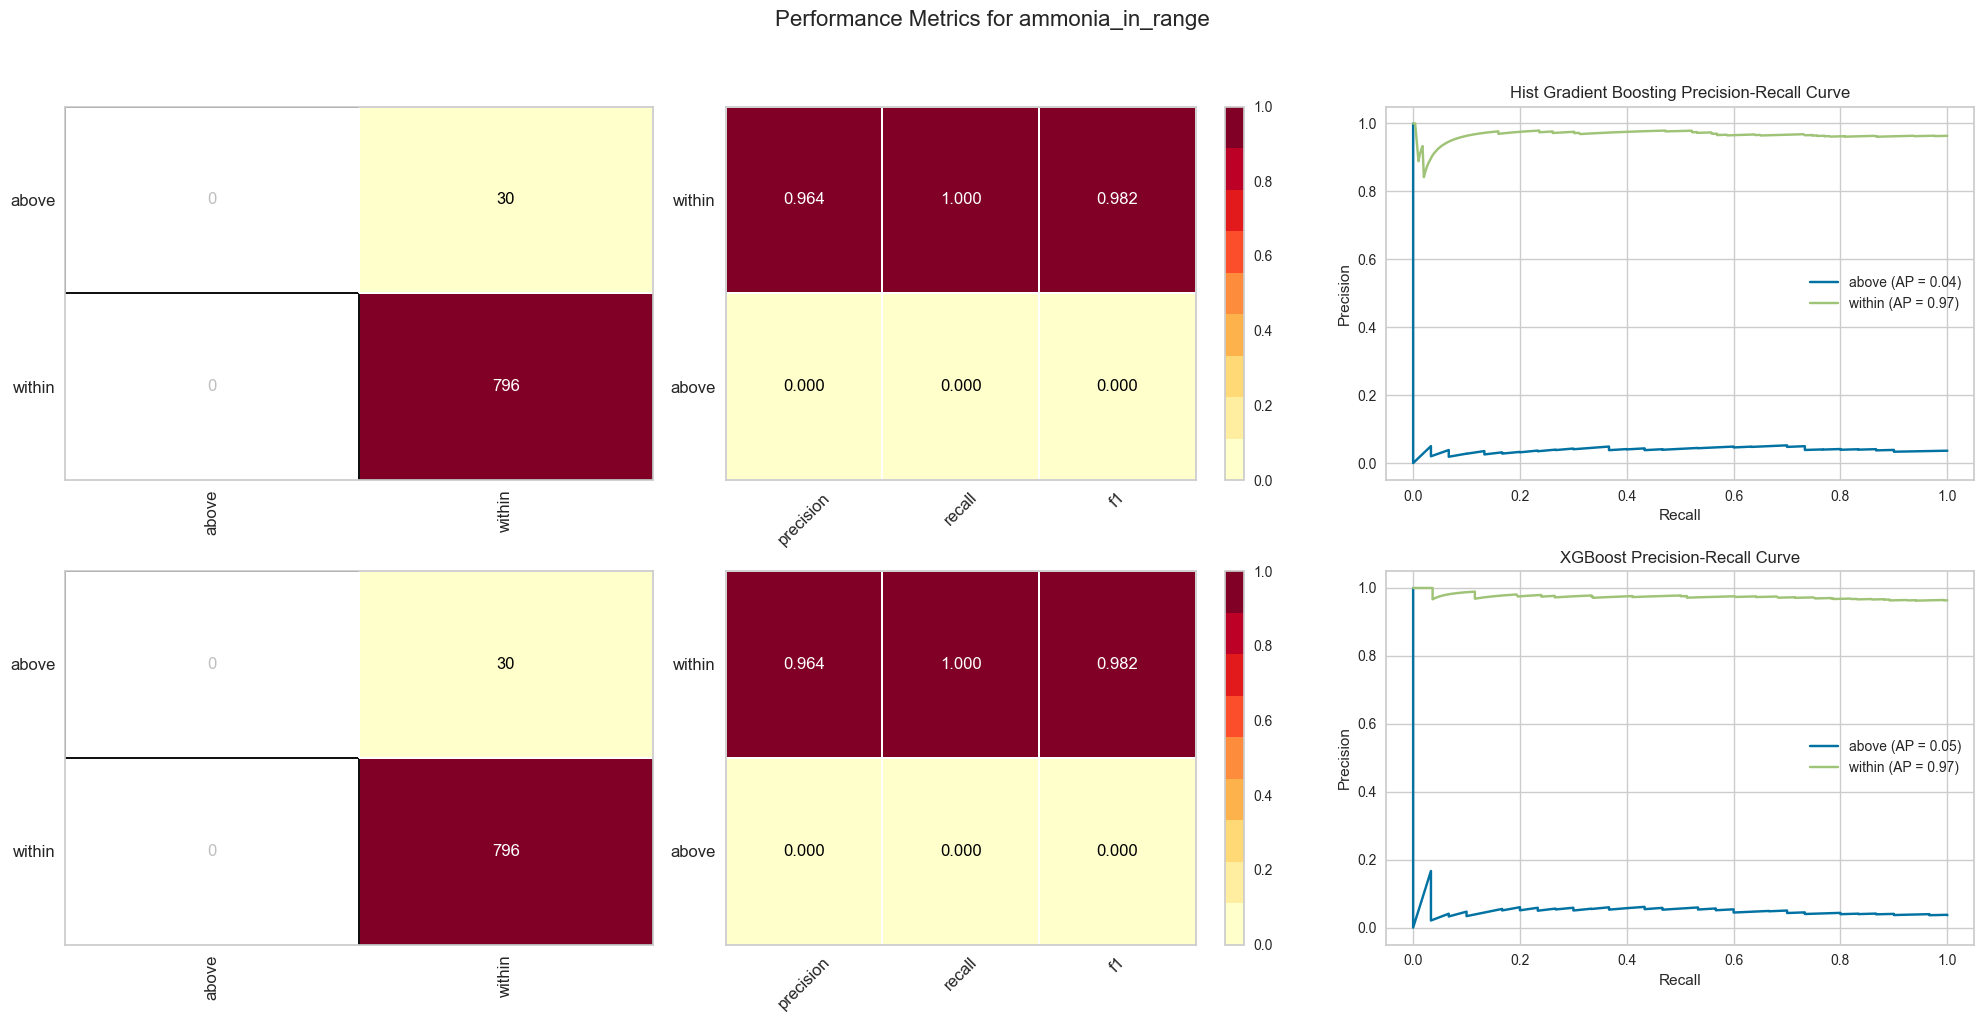

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being se

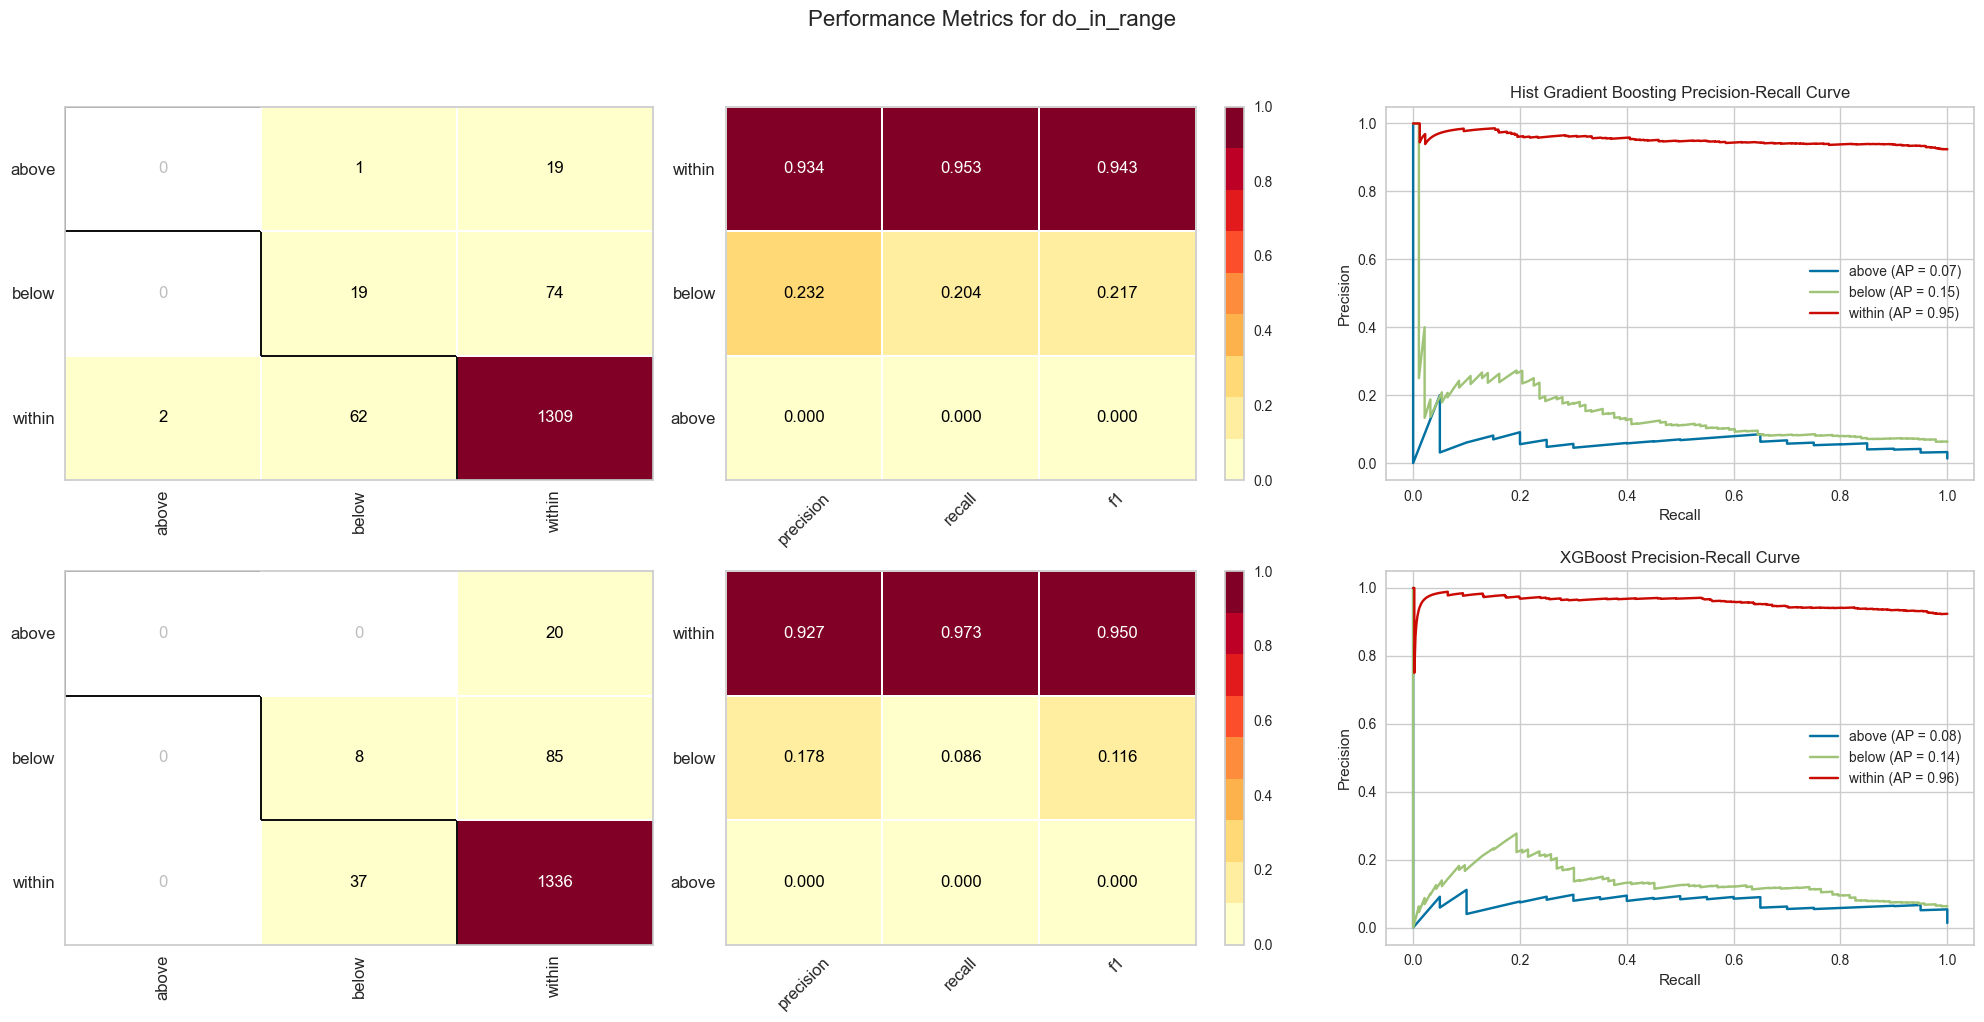

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter

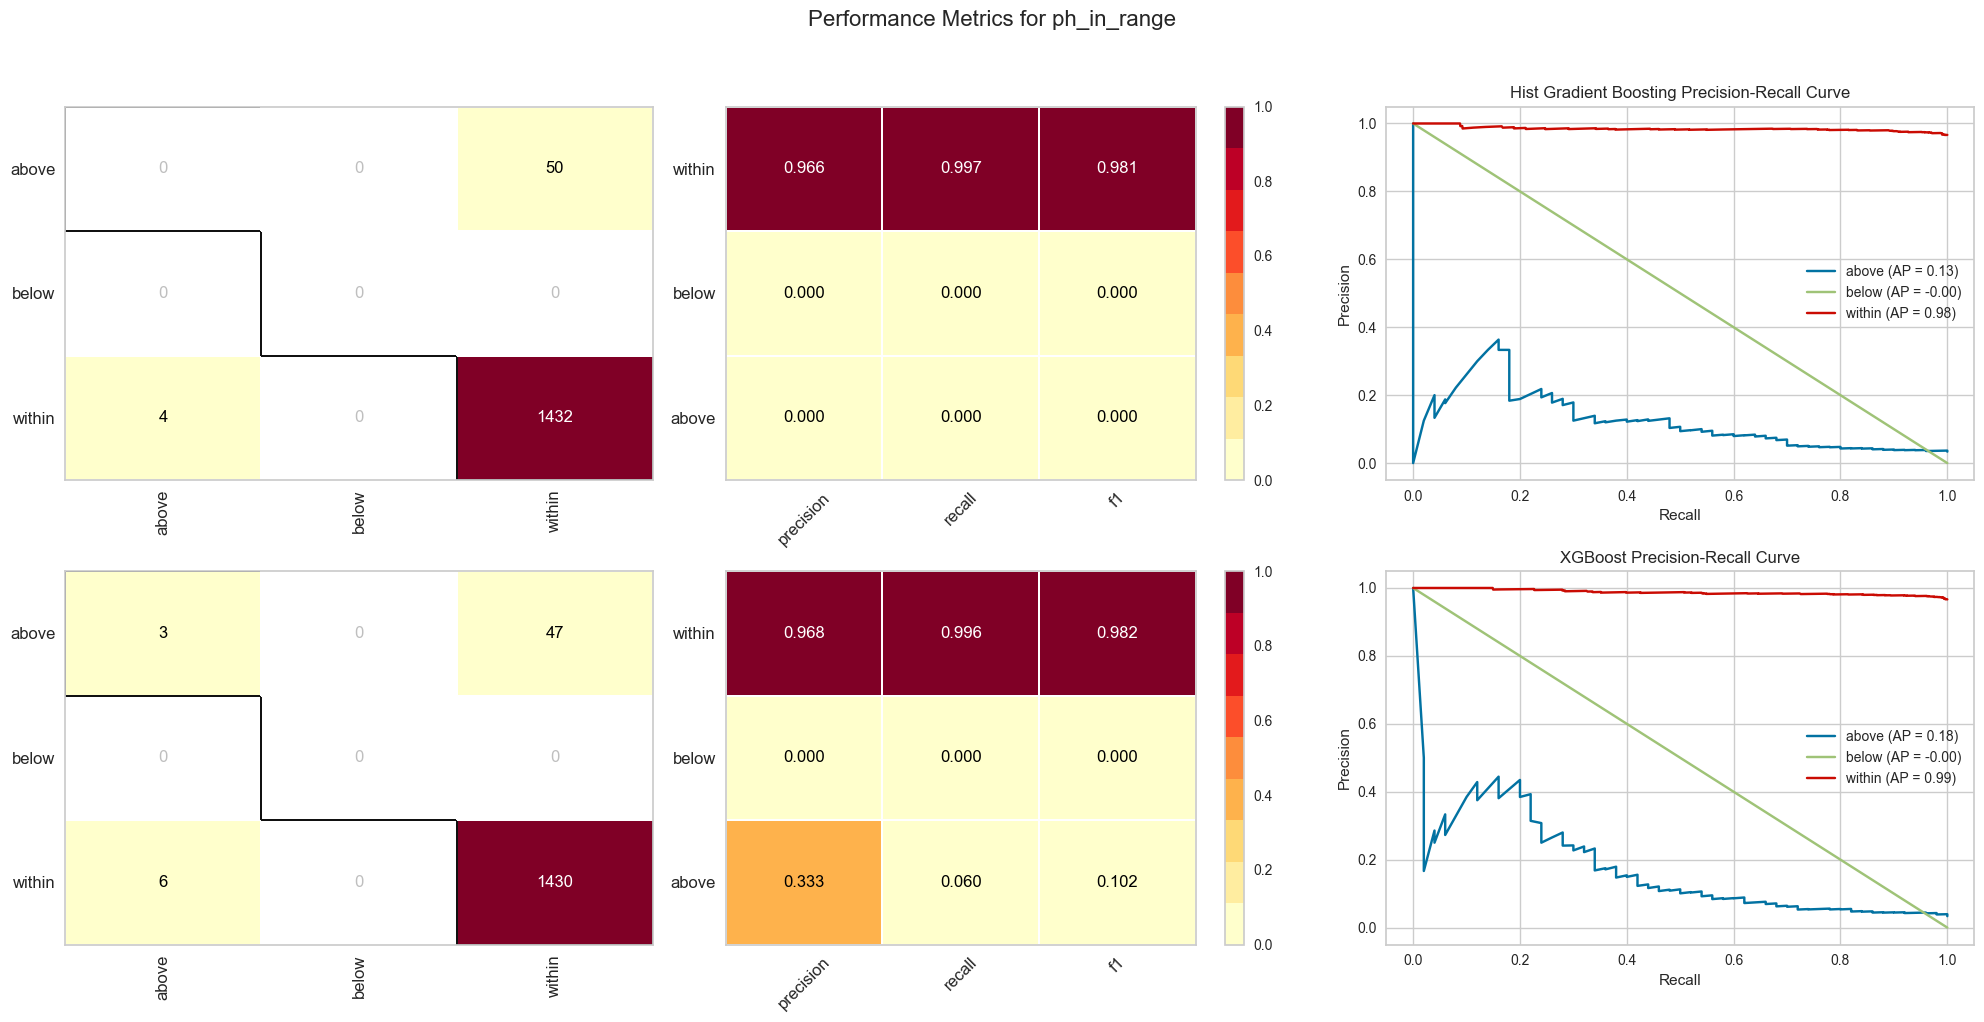

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\squaade\Documents\Githu

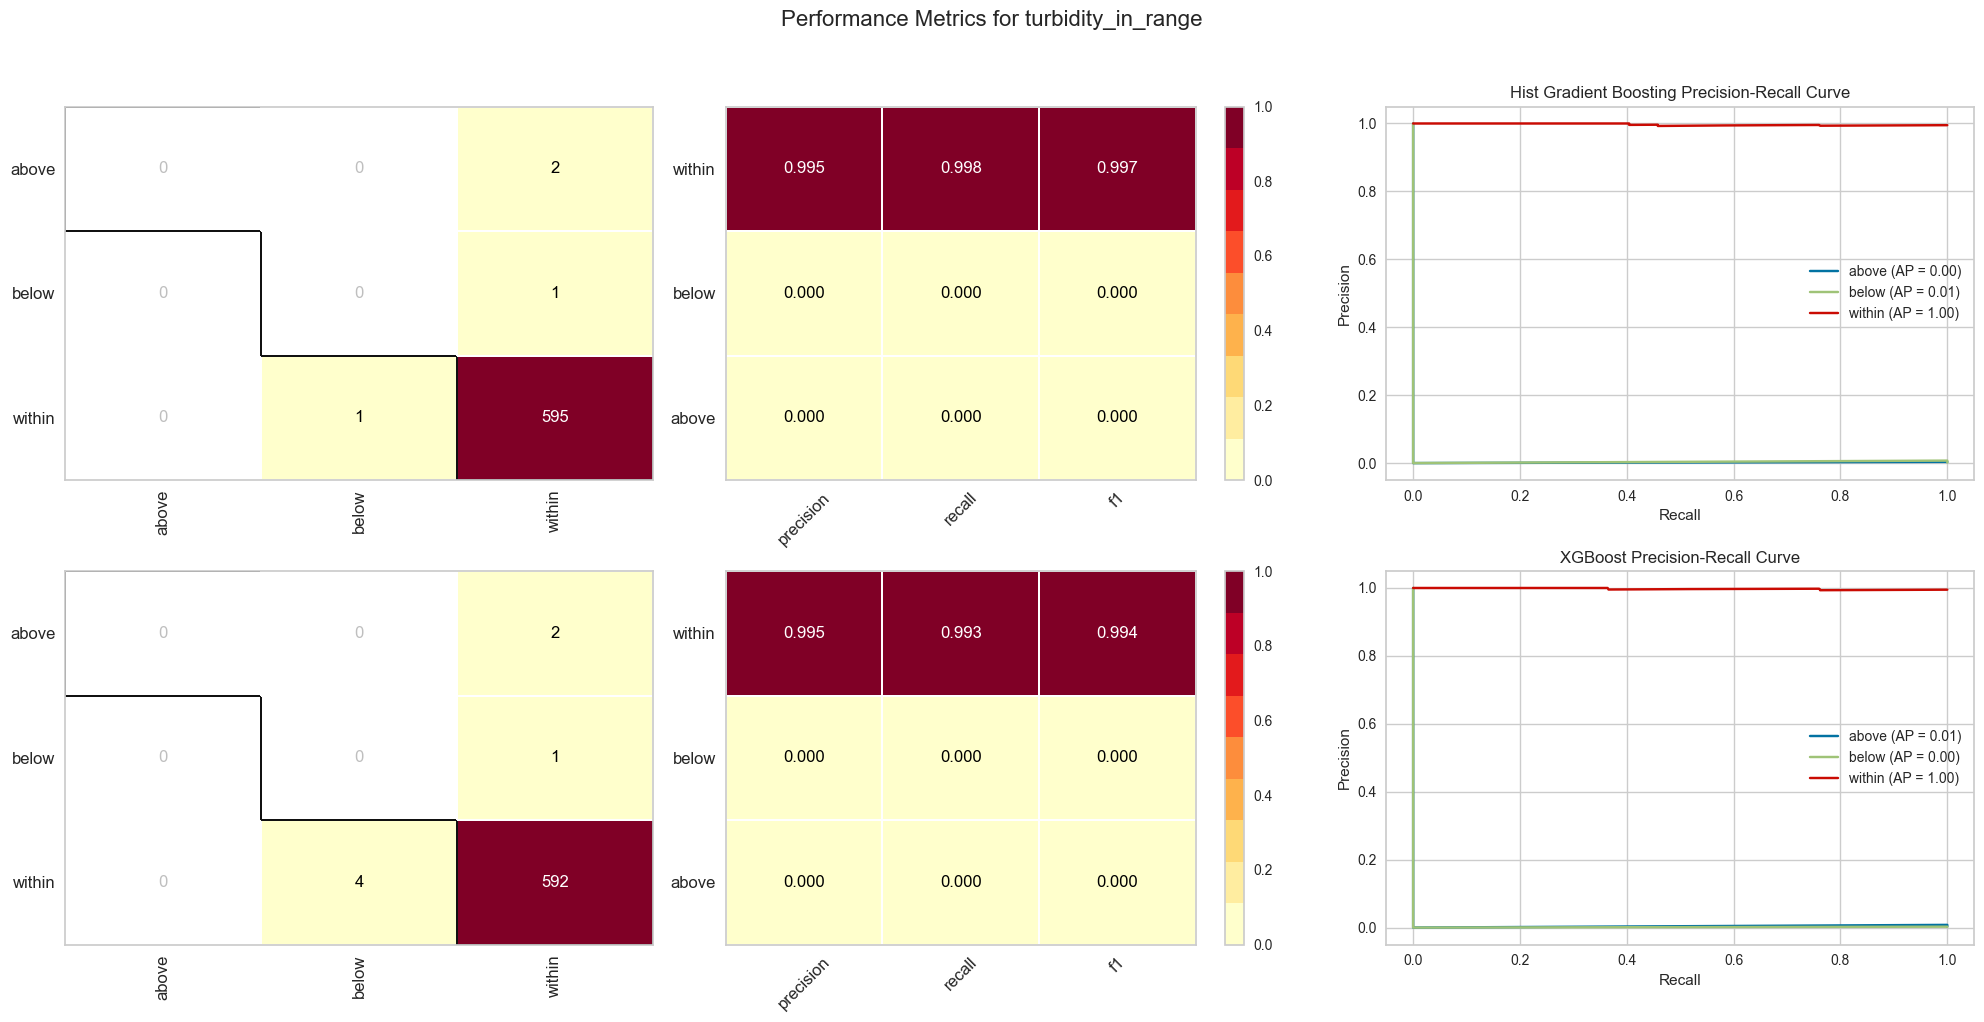

In [37]:
# Plot metrics for each target and its models
for target, target_dict in job_dict.items():
    models = target_dict['models']
    encoder = target_dict['encoder']
    
    # Get encoded target values
    y = ys[target]
    valid_idx = y.astype(bool)
    target_X = X[valid_idx.to_numpy()]
    y = y[valid_idx]
    y = encoder.transform(y)
    
    # Create figure with subplots
    n_models = len(models)
    fig, axes = plt.subplots(n_models, 3, figsize=(20, 5*n_models))
    fig.suptitle(f'Performance Metrics for {target}', fontsize=16, y=1.02)
    
    # If only one model, wrap axes in list for consistent indexing
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    # Plot metrics for each model
    for i, (model_name, model) in enumerate(models.items()):
        plot_model_metrics(
            target_X, y, model,
            model_name, encoder,
            axes[i,0], axes[i,1], axes[i,2]
        )
        
    plt.tight_layout()
    plt.show()


In [38]:
do_xg_model = job_dict['do_in_range']['models']['XGBoost']

<Figure size 2000x1000 with 0 Axes>

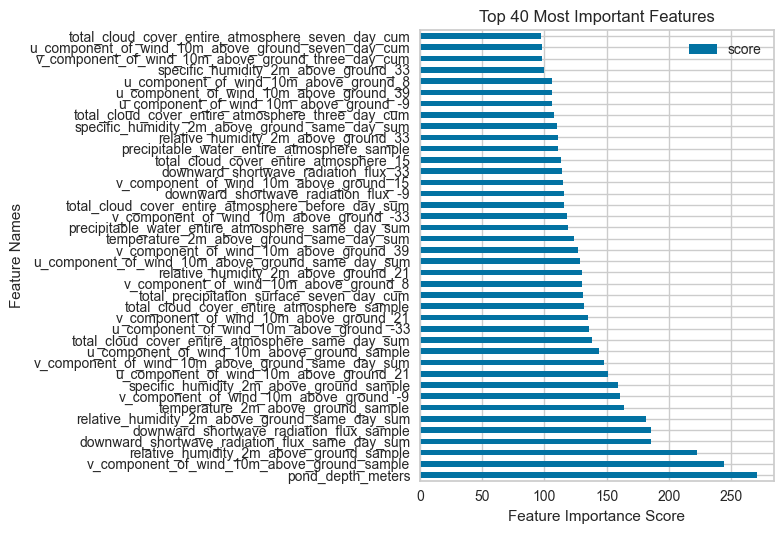

In [39]:
# Get feature importances with f{num} names
feature_importances = do_xg_model['classifier'].get_booster().get_score(importance_type='weight')

# Get the feature names from the preprocessor
feature_names = do_xg_model['scaler'].get_feature_names_out()

# Create mapping of f{num} to actual feature names
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}

# Convert importances to DataFrame with actual feature names
values = list(feature_importances.values())
keys = [feature_map[k] for k in feature_importances.keys()]

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by='score', ascending=False)

# Create plot with actual feature names
plt.figure(figsize=(20,10))
ax = data.nlargest(40, columns="score").plot(kind='barh')
ax.set_xlabel('Feature Importance Score')
ax.set_ylabel('Feature Names')
ax.set_title('Top 40 Most Important Features')

# Ensure feature names are fully visible
plt.tight_layout()

### Show train vs test set histograms sorted by feature importance

In [40]:
import seaborn as sns

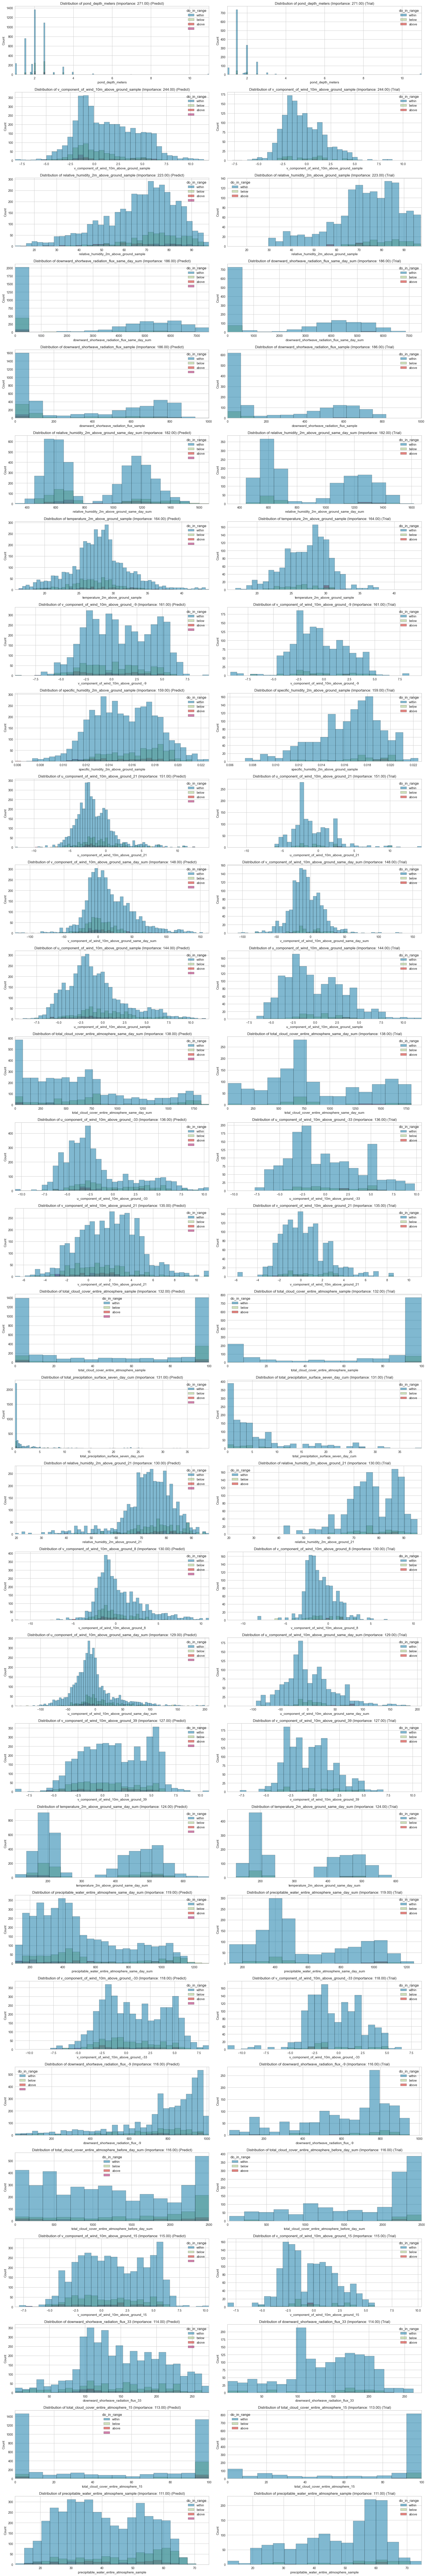

In [41]:
# Combine the datasets and add a source column
predict_df['source'] = 'predict'
trial_df['source'] = 'trial'

# Ensure both dataframes have the same columns
trial_df_all = trial_df.merge(jun_dec_samples, on='sample_idx')
common_cols = list(set(predict_df.columns) & set(trial_df_all.columns))
predict_df_common = predict_df[common_cols]
trial_df_common = trial_df_all[common_cols]

combined_df = pd.concat([predict_df_common, trial_df_common])

# Get feature importances and sort numeric columns by importance
feature_importances = do_xg_model['classifier'].get_booster().get_score(importance_type='weight')
feature_names = do_xg_model['scaler'].get_feature_names_out()
feature_map = {f'f{i}': name for i, name in enumerate(feature_names)}
importance_scores = {feature_map[k]: v for k, v in feature_importances.items()}

# Get top 30 features by importance
top_30_features = sorted(
    importance_scores.items(),
    key=lambda x: x[1],
    reverse=True
)[:30]
top_30_cols = [col for col, _ in top_30_features]

fig, axes = plt.subplots(30, 2, figsize=(20, 4*30))

# Plot histograms for each numeric column, side by side for each source
for i, col in enumerate(top_30_cols):
    # Get the overall min/max for consistent x-axis
    x_min = combined_df[col].min()
    x_max = combined_df[col].max()
    
    # Plot predict data
    sns.histplot(data=predict_df_common, x=col, hue='do_in_range',
                 multiple="layer", alpha=0.5, ax=axes[i,0])
    importance_text = f" (Importance: {importance_scores.get(col, 'Not in model'):.2f})" if col in importance_scores else " (Not in model)"
    axes[i,0].set_title(f'Distribution of {col}{importance_text} (Predict)')
    axes[i,0].set_xlim(x_min, x_max)
    
    # Plot trial data 
    sns.histplot(data=trial_df_common, x=col, hue='do_in_range',
                 multiple="layer", alpha=0.5, ax=axes[i,1])
    axes[i,1].set_title(f'Distribution of {col}{importance_text} (Trial)')
    axes[i,1].set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()

In [50]:
y_pred

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

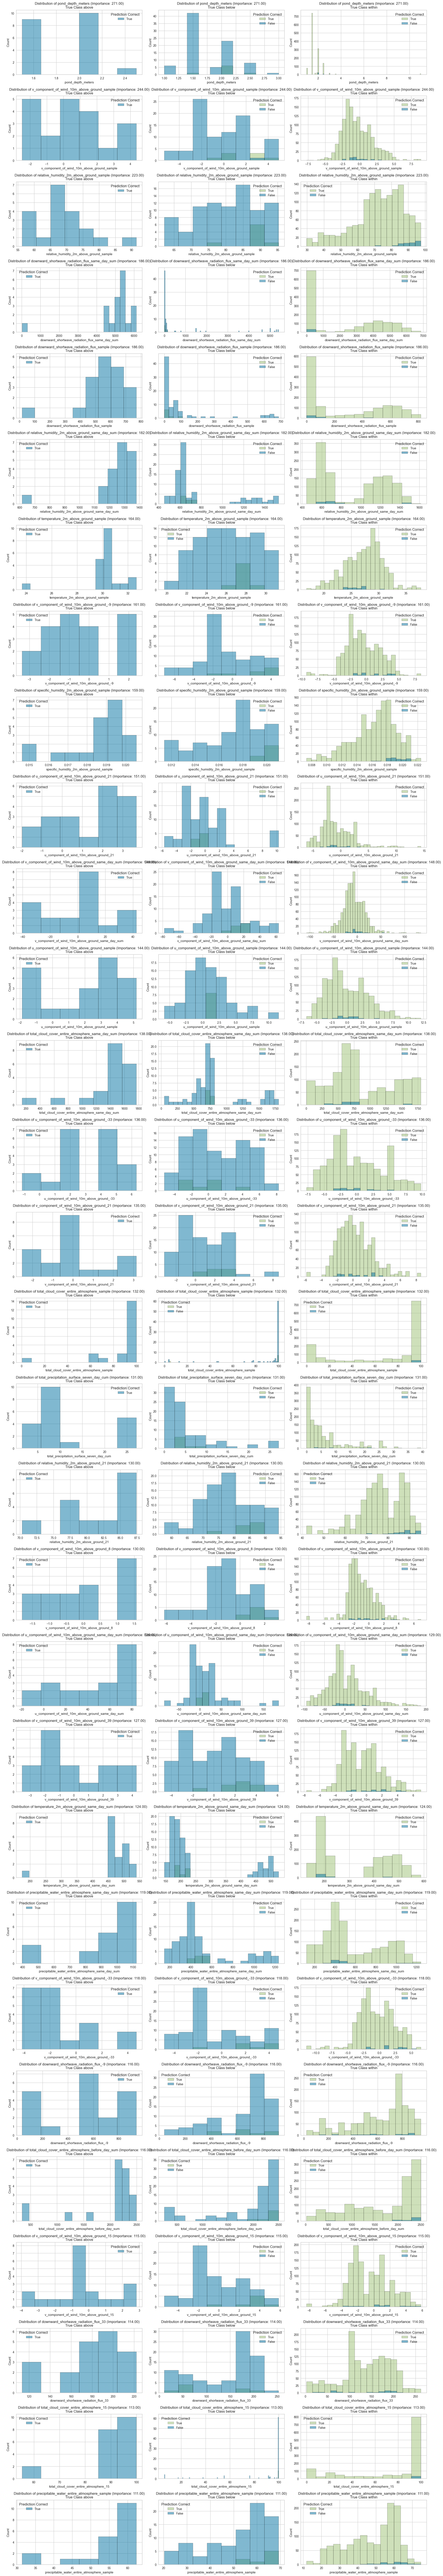

In [60]:
# Get predictions for jun_dec_test samples
encoder = job_dict['do_in_range']['encoder']
jun_dec_test_df = trial_df_all.copy()
y_pred = encoder.inverse_transform(
  do_xg_model.predict(jun_dec_test_df[feature_names])
)

# Add prediction correctness column
jun_dec_test_df['prediction_correct'] = (y_pred == jun_dec_test_df['do_in_range'])
jun_dec_test_df['predicted_class'] = y_pred

# Get top 30 features by importance
top_30_features = sorted(
    importance_scores.items(),
    key=lambda x: x[1],
    reverse=True
)[:30]
top_30_cols = [col for col, _ in top_30_features]

# Create subplots with 3 columns for each feature
n_cols = len(top_30_cols)
fig, axes = plt.subplots(n_cols, 3, figsize=(20, 4*n_cols))

# Plot histograms for each feature and class
for i, col in enumerate(top_30_cols):
    importance_text = f" (Importance: {importance_scores.get(col, 'Not in model'):.2f})"
    
    # Plot for each true class (0, 1, 2)
    for j, class_val in enumerate(encoder.classes_):
        class_data = jun_dec_test_df[jun_dec_test_df['do_in_range'] == class_val]
        if len(class_data) > 0:  # Only plot if there is data for this class
            sns.histplot(data=class_data, x=col, hue='prediction_correct',
                        multiple="layer", alpha=0.5, ax=axes[i,j])
            axes[i,j].set_title(f'Distribution of {col}{importance_text}\nTrue Class {class_val}')
            axes[i,j].set_xlabel(col)
            axes[i,j].legend(title='Prediction Correct', labels=['True', 'False'])
        else:
            axes[i,j].set_title(f'No data for class {class_val}')

plt.tight_layout()
plt.show()


In [43]:
L

NameError: name 'L' is not defined